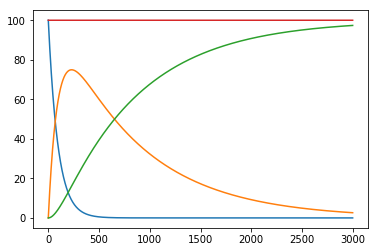

In [13]:
import math
import csv
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

#The input format is a comma separated list, where each value has its own row
csv_arr = []

#Currently the values are in minutes, this may change later on
with open('input_file.csv') as csv_in:
  filereader = csv.reader(csv_in)
  for row in filereader:
    csv_arr.append(row[0])

#The lambda values are input into the file precalculated from half-life
a_lambda = float(csv_arr[0])
b_lambda = float(csv_arr[1])

#The initial values
parent_init = float(csv_arr[2])
daughter_init = float(csv_arr[3])
stable_init = float(csv_arr[4])

#The delta t value
delta = float(csv_arr[5])

#The endtime
endtime = float(csv_arr[6])

#The constant production rate for both daughters
daughter_q = (parent_init * a_lambda) / (b_lambda - a_lambda)
stable_q = (parent_init/(b_lambda - a_lambda))

#The rest of this block of code is the analytical solution
x = np.arange(0, endtime, delta)

#This calculates decay of the parent
def parent_decay(time): 
  return parent_init*(np.exp(-(a_lambda*time)))

y = parent_decay(x)

#Calculates both the decay and growth of the first daughter
def daughter_decay(time):
  return daughter_init*(np.exp(-b_lambda*time)) + daughter_q * (np.exp(-a_lambda*time) - np.exp(-b_lambda*time))

z = daughter_decay(x)

#Calculates the growth of the third daughter
def stable_growth(time):
  return stable_init + daughter_init*(1 - np.exp(-b_lambda*time)) + stable_q * (b_lambda * (1 - np.exp(-a_lambda * time)) - a_lambda * (1 - np.exp(-b_lambda * time)))

a = stable_growth(x)

b = np.add(np.add(y, z), a)

plt.plot(x,y)
plt.plot(x,z)
plt.plot(x,a)
plt.plot(x,b)

C:\Users\akfly\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


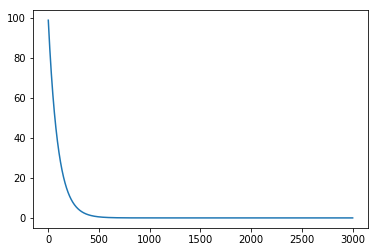

In [24]:
#This block is for the numerical solutions

#This takes the delta T and provides an array of values
def num_parent_decay(shift):
    jump = int(endtime/shift)
    time_step = np.linspace(0, endtime, num=jump)
    parent_amounts = np.zeros(jump)
    point = 0
    for i in time_step:
        value = -(a_lambda*shift*parent_decay(i))+parent_decay(i)
        parent_amounts[point] = value
        point = point+1
    return parent_amounts

c = num_parent_decay(int(delta))
time_skip = endtime/delta
d = np.linspace(0, endtime, num=time_skip)
plt.plot(d,c)
        